In [142]:
import numpy as np
import pandas as pd
from datetime import datetime
import gzip
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
from collections import defaultdict

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import auc, roc_auc_score, roc_curve, average_precision_score
from sklearn.metrics import precision_recall_curve, classification_report, accuracy_score
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

from sklearn.preprocessing import MinMaxScaler

import optuna
from optuna.samplers import TPESampler

import shap

def plot_AUC(y_real, predictions):
    AUC_PR_mean = []
    AUC_ROC_mean = []
    for y_r, y_p in zip(y_real, predictions):
        
        positive = y_r.sum()
        
        plt.figure(figsize=(16, 8))

        plt.subplot(121)
        precision, recall, thresholds = precision_recall_curve(y_r, y_p)
        plt.plot(recall, precision, lw = 1.5, label='PR curve')
        plt.axhline(positive/y_r.shape[0], 0, 1, linestyle='--', color='r')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('PR curve')
        plt.legend(['LightGBM', 'Random Classifier'])
        plt.grid()

        AUC_PR = auc(recall, precision)

        plt.subplot(122)
        fpr, tpr, thresholds = roc_curve(y_r, y_p)
        plt.plot(fpr, tpr, lw=1.5, label='ROC curve')
        plt.plot([0, 1], [0, 1], linestyle='--', color='r')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.02])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(['LightGBM', 'Random Classifier'])

        AUC_ROC = auc(fpr, tpr)
        
        plt.grid()
        plt.tight_layout()
        plt.show()
        
        print('AUC-PR - {}'.format(round(AUC_PR, 5)))
        print('AUC-ROC - {}'.format(round(AUC_ROC, 5)))
        
        AUC_PR_mean.append(AUC_PR)
        AUC_ROC_mean.append(AUC_ROC)
    
    print('MEAN AUC-PR - {}'.format(round(np.array(AUC_PR_mean).mean(), 5)))
    print('MEAN AUC-ROC - {}'.format(round(np.array(AUC_ROC_mean).mean(), 5)))
    
    
def print_results(study):
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial
    print("  AUC_ROC: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

# 0. Обработка сырых данных

In [3]:
# with gzip.open('accepted_2007_to_2018Q4.csv.gz', 'rb') as f:
#     accepted = pd.read_csv(f)

Сразу удалим топ N признаков, имеющих наибольшее количество пропусков (более 50 тыс.).

In [ ]:
accepted_nulls = accepted.isnull().sum().sort_values(ascending=False)
cols_to_drop = accepted_nulls[accepted_nulls > 50000].index
accepted = accepted.drop(columns=cols_to_drop)

Описание признаков можно найти здесь  https://rstudio-pubs-static.s3.amazonaws.com/115829_32417d32dbce41eab3eeaf608a0eef9d.html

или здесь https://github.com/dosei1/Lending-Club-Loan-Data/blob/master/LCDataDictionary.csv

Удалим дополнительно признаки, которые не несут смысла для модели (или очень сложно использовать) и в которых возможен лик

In [ ]:
col_drop = ['funded_amnt', 'funded_amnt_inv', 'pymnt_plan', 'url', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec',
           'revol_bal', 'revol_util', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 
            'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
            'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 
            'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med',
           'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'hardship_flag', 'debt_settlement_flag']

In [ ]:
accepted = accepted.drop(columns=col_drop)

Описание признаков:
1. id - id заявки
1. loan_amnt - сумма долга (сильно скорелирован с funded_amnt и funded_amnt_inv)
1. term - срок кредита
1. int_rate - % ставка кредита
1. installment - ежемесячный платеж 
1. grade - кредитный рейтинг заемщика (должна проставляться до выдачи кредита, те. можно использовать)
1. sub_grade - подгруппа кредитного рейтинг 
1. home_ownership - тип жилья клиента 
1. annual_inc - годовой доход клиента 
1. verification_status - статус дохода клиента (подтвержден или нет)
1. issue_d - дата выдачи кредита
1. loan_status	- статус заявки (наша целевая переменная)
1. purpose - на что взят кредит 
1. title - подкатегория взятия кредита
1. zip_code - почтовый индекс
1. addr_state - штат клиента
1. dti - Debt-to-income ratio, долг к доходу
1. earliest_cr_line - The date the borrower's earliest reported (дата первого кредита)
1. fico_range_low - нижнее значение кредитного рейтинга ФИКО
1. fico_range_high - верхнее значение кредитного рейтинга ФИКО
1. open_acc - Количество открытых кредитных линий в кредитное досье заемщика.
1. total_acc - Общее количество кредитных линий в досье заемщика
1. policy_code - код продукта (общедоступность продукта)
1. application_type - тип заема (индивидуальный или в группе)
1. pub_rec_bankruptcies - количество несостоятельностей клиента (вроде можно использовать, но может быть и лик)
1. tax_liens - количество налогового залога
1. disbursement_method - как были выданы деньги

# Предобработка признаков

Оставим только то, что будем предсказывать:
- Fully Paid - Кредит полностью выплачен
- Charged Off,  Does not meet the credit policy. Status:Charged Off, Default - дефолт

In [ ]:
accepted = accepted[accepted.loan_status.isin(['Fully Paid', 'Charged Off', 'Default',
       'Does not meet the credit policy. Status:Charged Off'])]
accepted.loan_status = accepted.loan_status.apply(lambda x: 0 if x =='Fully Paid' else 1)

Приведение признаков к нормальной форме:

In [ ]:
accepted.id = accepted.id.astype(np.int64)
accepted.term = accepted.term.apply(lambda x: x[0:3]).astype(int)

grades = sorted(accepted.grade.unique())
grades = {k:v for v, k in enumerate(grades)}
accepted.grade = accepted.grade.map(grades)

grades = sorted(accepted.sub_grade.unique())
grades = {k:v for v, k in enumerate(grades)}
accepted.sub_grade = accepted.sub_grade.map(grades)

zip_code = accepted.zip_code.value_counts().head(50).index
accepted.zip_code = accepted.zip_code.apply(lambda x: x[:3] if x in zip_code else 0).astype(int)

accepted.earliest_cr_line = accepted.earliest_cr_line.astype(np.datetime64)
accepted.issue_d = accepted.issue_d.astype(np.datetime64)

In [ ]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns 
        
    def fit(self,X,y=None):
        return self 

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)
    
    
cat = ['home_ownership', 'verification_status', 'purpose', 'title', 'zip_code', 
       'addr_state', 'application_type', 'disbursement_method']   
accepted = MultiColumnLabelEncoder(columns = cat).fit_transform(accepted)

In [ ]:
accepted = accepted.sort_values(by='issue_d')

#### Заполнение пропусков

In [ ]:
accepted.dti.fillna(accepted.dti.mean(), inplace = True)
accepted['earliest_cr_before_this'] = (accepted.issue_d  - accepted.earliest_cr_line)
accepted.earliest_cr_before_this = accepted.earliest_cr_before_this.apply(lambda x: x.days).fillna(0)
accepted = accepted.drop(['earliest_cr_line'], axis=1)
accepted.total_acc.fillna(0, inplace = True)
accepted.pub_rec_bankruptcies.fillna(0, inplace = True)
accepted.tax_liens.fillna(0, inplace = True)
accepted.open_acc.fillna(0, inplace = True)
accepted.policy_code.fillna(0, inplace = True)

In [ ]:
accepted.to_csv('accepted.csv', index=False)

# Обработка данных для логистической регрессии

In [89]:
df = pd.read_csv('accepted.csv', parse_dates =['issue_d'])

#### OHE

In [90]:
OHE_cat = ['home_ownership', 'verification_status', 'purpose', 'addr_state']   

enc = OneHotEncoder(drop='first', sparse=False)
for OHE in OHE_cat:
    col = enc.fit_transform(df[OHE].values.reshape(-1, 1))
    hot_col = pd.DataFrame(col, columns=[OHE + '_' + str(i) for i in range(col.shape[1])])
    df = pd.concat([df, hot_col], axis=1)

#### Выделим обучающую, валидационную и тестовую часть

In [91]:
test = df[df.issue_d >= np.datetime64('2017-01-01')].drop(['issue_d', 'id'], axis=1)
train = df[df.issue_d < np.datetime64('2017-01-01')].drop(['issue_d', 'id'], axis=1)
X_test, y_test = test.drop('loan_status', axis=1), test.loan_status
X, y = train.drop('loan_status', axis=1), train.loan_status

#### Скалирование переменных

In [92]:
scaler = MinMaxScaler()

X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=X_test.columns)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X.columns)

# 2. Разбейте выборку на несколько частей для построения модели и анализа качества

In [93]:
train_inx = range(int(y.shape[0]*0.7)) 
val_inx = range(int(y.shape[0]*0.7)+1, y.shape[0])

In [94]:
X_train, X_val = X.loc[train_inx], X.loc[val_inx]
X_global_train = pd.concat([X_train, X_val], ignore_index=True)
y_train, y_val = y.loc[train_inx], y.loc[val_inx]
y_global_train = pd.concat([y_train, y_val], ignore_index=True)

## Запишем результаты

In [95]:
pos = y_global_train.sum() / y_global_train.shape[0] 
neg = (y_global_train.shape[0] - y_global_train.sum()) / y_global_train.shape[0]

results = pd.DataFrame({'random_classifier': [0.5, 0.5, pos, 0.5, 0.5, neg**2+pos**2]})

results.index = ['Precision', 'Recall', 'AUC-PR', 'AUC-ROC', 'F1_score', 'Accuracy']

### 3. Постройте интерпретируемый скоринг (Логистическая регрессия)

In [44]:
# sampler=TPESampler(seed=10)

# def objective_LR(trial):
#     tol = trial.suggest_uniform('tol ', 1e-5, 1e-3)
#     C = trial.suggest_uniform('C', 0.01, 1)
    
#     LR = LogisticRegression(tol=tol, C=C, max_iter=1000, n_jobs=-1, random_state=77, class_weight='balanced')
#     LR.fit(X_train, y_train)
#     preds = LR.predict_proba(X_val)[:,1]
#     ROC_AUC = roc_auc_score(y_val, preds)
#     return ROC_AUC

# study_lr = optuna.create_study(direction="maximize", sampler=sampler)
# study_lr.optimize(objective_LR, n_trials=100, timeout=None, n_jobs=-1)

In [45]:
# print_results(study_lr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    177596
           1       0.21      1.00      0.35     48043

    accuracy                           0.21    225639
   macro avg       0.11      0.50      0.18    225639
weighted avg       0.05      0.21      0.07    225639



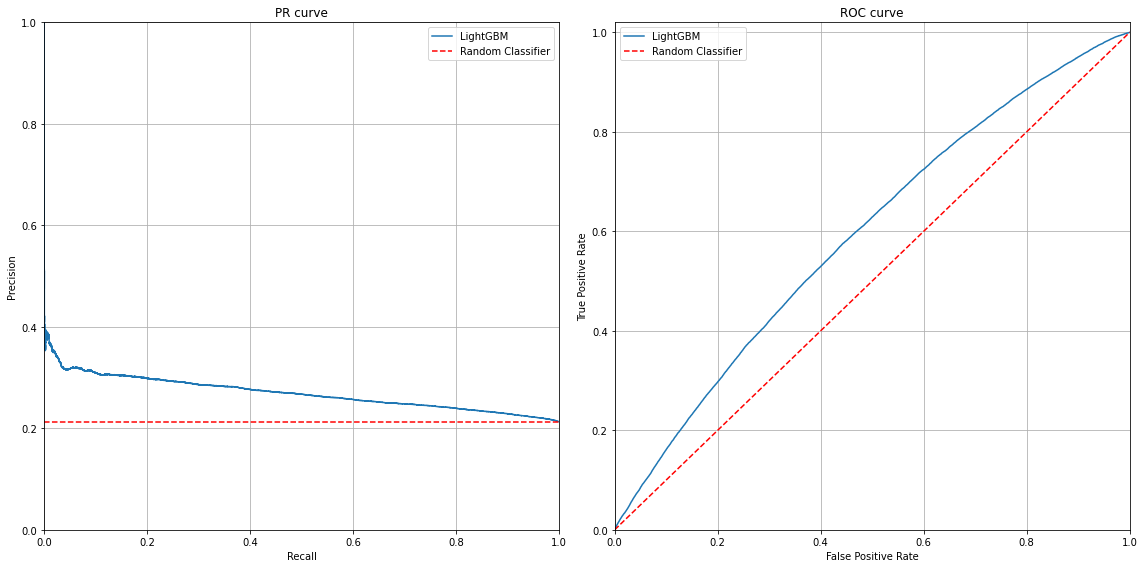

AUC-PR - 0.2696
AUC-ROC - 0.59212
MEAN AUC-PR - 0.2696
MEAN AUC-ROC - 0.59212


In [46]:
LR = LogisticRegression(penalty='l2', tol= 0.001, class_weight={0:1, 1:4}, C=0.21)
LR.fit(X_global_train, y_global_train)
preds = LR.predict_proba(X_test)[:,1]
preds_0_1 = np.where((preds >= 0.5), 1, 0)

precision = precision_score(y_test, preds_0_1, average='macro')
recall = recall_score(y_test, preds_0_1, average='macro')
AUC_PR = average_precision_score(y_test, preds)
AUC_ROC = roc_auc_score(y_test, preds)
f1 = f1_score(y_test, preds_0_1, average='macro')
accuracy = accuracy_score(y_test, preds_0_1)
results['Log_Reg'] = [precision, recall, AUC_PR, AUC_ROC, f1, accuracy]

print(classification_report(y_test, np.where((preds >= 0.5), 1, 0)))
plot_AUC([y_test], [preds])

In [ ]:
results

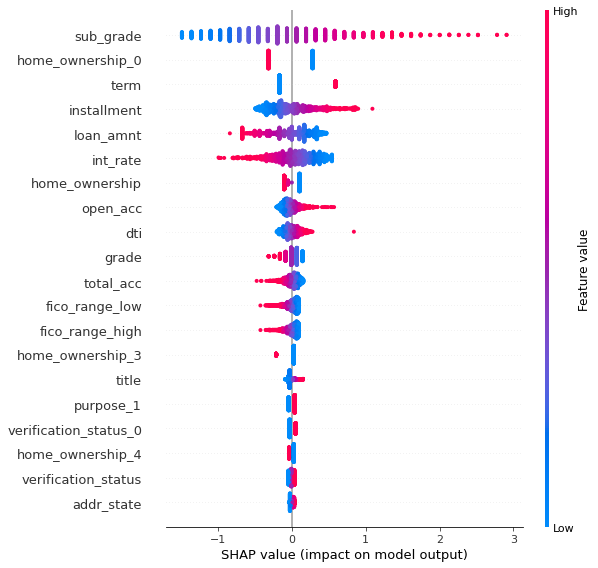

In [96]:
sample = X_global_train.sample(1000)
explainer = shap.Explainer(LR, sample)
shap_values = explainer(sample)
shap.summary_plot(shap_values, sample)

# 4. Постройте любую модель машинного обучения на этих же данных с качеством выше (LightGBM)

In [97]:
df = pd.read_csv('accepted.csv', parse_dates =['issue_d'])
cat = ['home_ownership', 'verification_status', 'purpose', 'title', 'zip_code', 
       'addr_state', 'application_type', 'disbursement_method']   

In [98]:
test = df[df.issue_d >= np.datetime64('2017-01-01')].drop(['issue_d', 'id'], axis=1)
train = df[df.issue_d < np.datetime64('2017-01-01')].drop(['issue_d', 'id'], axis=1)
X_test, y_test = test.drop('loan_status', axis=1), test.loan_status
X, y = train.drop('loan_status', axis=1), train.loan_status

train_inx = range(int(y.shape[0]*0.7)) 
val_inx = range(int(y.shape[0]*0.7)+1, y.shape[0])

X_train, X_val = X.loc[train_inx], X.loc[val_inx]
X_global_train = pd.concat([X_train, X_val], ignore_index=True)
y_train, y_val = y.loc[train_inx], y.loc[val_inx]
y_global_train = pd.concat([y_train, y_val], ignore_index=True)

In [99]:
dtrain_global = lgb.Dataset(X_global_train, label=y_global_train, categorical_feature=cat, free_raw_data=False)
dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cat, free_raw_data=False)

С тюнингом

In [102]:
param = {'num_leaves': 89,
      'min_child_samples': 29,
      'objective': 'binary',
      'max_depth': 21,
      'learning_rate': 0.012,
      "boosting_type": "gbdt",
      "metric": 'auc',
      'reg_alpha': 0.22,
      'reg_lambda': 0.2,
     'is_unbalance': True,
         'verbose': -1}

gbm = lgb.train(param, dtrain_global, num_boost_round=1000)
preds = gbm.predict(X_test)
preds_0_1 = np.where((preds >= 0.5), 1, 0)

precision = precision_score(y_test, preds_0_1, average='macro')
recall = recall_score(y_test, preds_0_1, average='macro')
AUC_PR = average_precision_score(y_test, preds)
AUC_ROC = roc_auc_score(y_test, preds)
f1 = f1_score(y_test, preds_0_1, average='macro')
accuracy = accuracy_score(y_test, preds_0_1)
results['LightGBM'] = [precision, recall, AUC_PR, AUC_ROC, f1, accuracy]

              precision    recall  f1-score   support

           0       0.89      0.57      0.70    177596
           1       0.32      0.74      0.44     48043

    accuracy                           0.61    225639
   macro avg       0.60      0.66      0.57    225639
weighted avg       0.77      0.61      0.64    225639



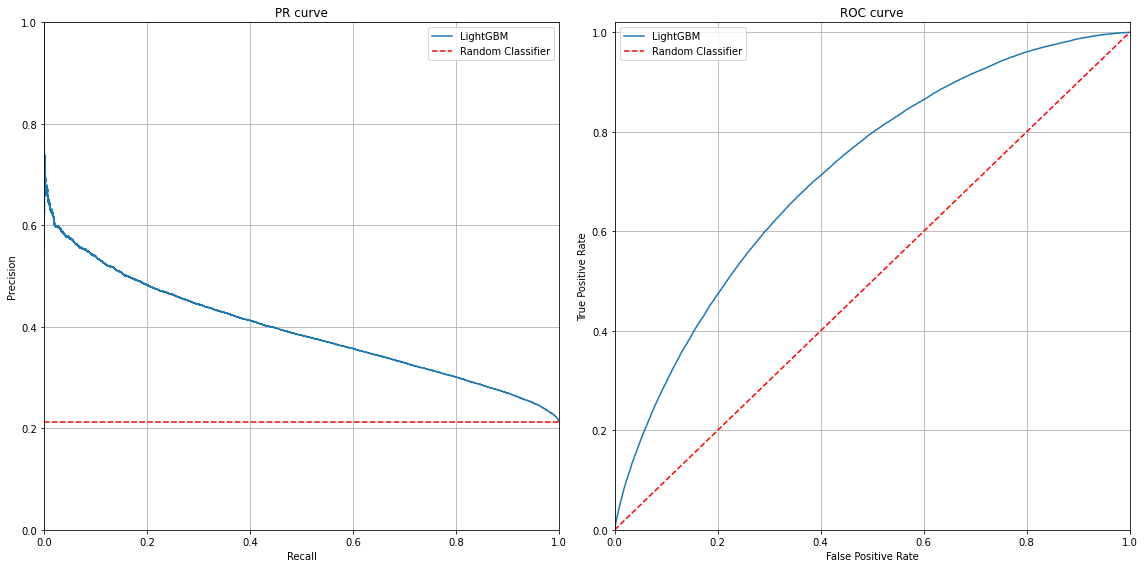

AUC-PR - 0.39411
AUC-ROC - 0.71613
MEAN AUC-PR - 0.39411
MEAN AUC-ROC - 0.71613


In [19]:
print(classification_report(y_test, np.where((preds >= 0.5), 1, 0)))
plot_AUC([y_test], [preds])

In [122]:
results

,random_classifier,LightGBM
Precision,0.500000,0.605590
Recall,0.500000,0.654729
AUC-PR,0.197521,0.386398
AUC-ROC,0.500000,0.712858
F1_score,0.500000,0.590746
Accuracy,0.682987,0.641919


# важность признаков

In [129]:
feature = pd.DataFrame({
    'feature_name': X_train.columns,
    'importance': gbm.feature_importance('gain')
})

feature_sorted = feature.sort_values(by='importance', ascending=False)

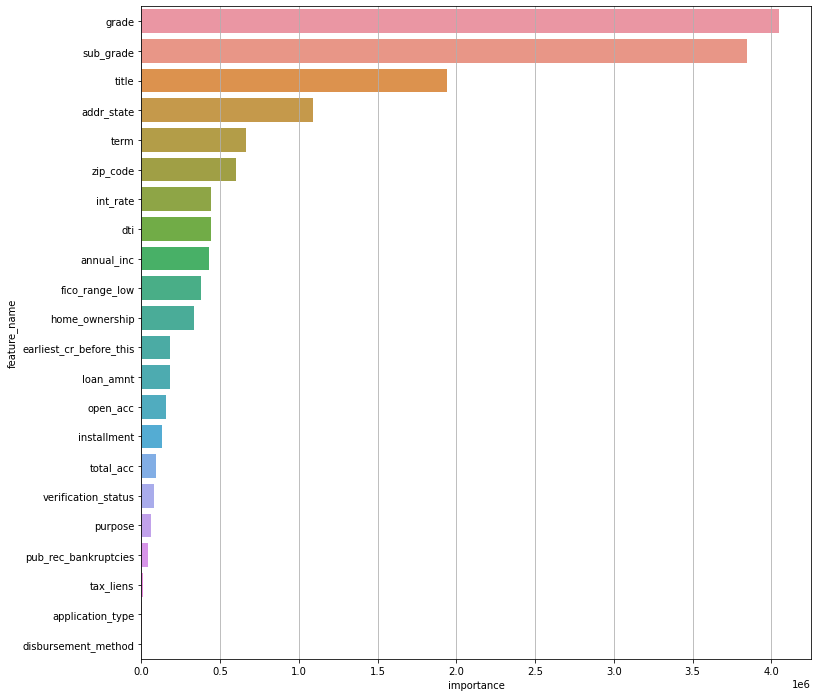

In [130]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.grid()
sns.barplot(x="importance", y="feature_name", data=feature_sorted[feature_sorted.importance != 0])

plt.show()

### Shap

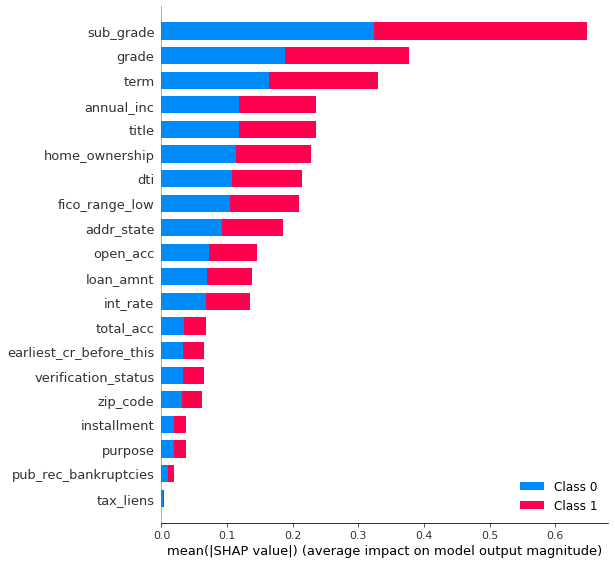

In [120]:
sample = X_train.sample(1000)

shap_values = shap.TreeExplainer(gbm).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

### 5.  c) Переобучение. Нет ли признаков переобучения модели?

In [125]:
preds = gbm.predict(X_global_train)
preds_0_1 = np.where((preds >= 0.5), 1, 0)

precision = precision_score(y_global_train, preds_0_1, average='macro')
recall = recall_score(y_global_train, preds_0_1, average='macro')
AUC_PR = average_precision_score(y_global_train, preds)
AUC_ROC = roc_auc_score(y_global_train, preds)
f1 = f1_score(y_global_train, preds_0_1, average='macro')
accuracy = accuracy_score(y_global_train, preds_0_1)
results['LightGBM_train'] = [precision, recall, AUC_PR, AUC_ROC, f1, accuracy]

              precision    recall  f1-score   support

           0       0.90      0.66      0.76    899154
           1       0.34      0.71      0.46    221317

    accuracy                           0.67   1120471
   macro avg       0.62      0.69      0.61   1120471
weighted avg       0.79      0.67      0.70   1120471



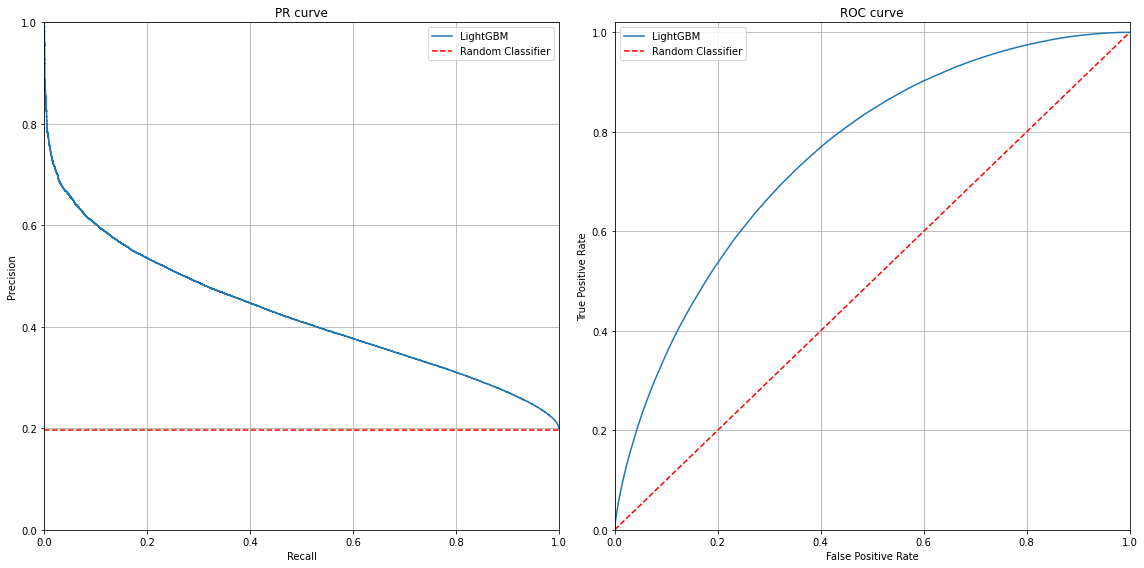

AUC-PR - 0.42628
AUC-ROC - 0.754
MEAN AUC-PR - 0.42628
MEAN AUC-ROC - 0.754


,random_classifier,LightGBM,LightGBM_train
Precision,0.500000,0.605590,0.621578
Recall,0.500000,0.654729,0.685800
AUC-PR,0.197521,0.386398,0.426281
AUC-ROC,0.500000,0.712858,0.754002
F1_score,0.500000,0.590746,0.611895
Accuracy,0.682987,0.641919,0.671103


In [127]:
print(classification_report(y_global_train, np.where((preds >= 0.5), 1, 0)))
plot_AUC([y_global_train], [preds])
results

### 5.  d) Простота модели. Нельзя ли упростить модель, не сильно потеряв при этом в качестве?

Дропаем:
- pub_rec_bankruptcies	
- tax_liens	
- application_type	
- disbursement_method	
- fico_range_high	
- policy_code	

In [140]:
col_drop = feature_sorted[feature_sorted.importance < 5e+04].feature_name

X_test = X_test.drop(col_drop, axis=1)
X_global_train = X_global_train.drop(col_drop, axis=1)

cat.remove('application_type')
cat.remove('disbursement_method')
dtrain_global = lgb.Dataset(X_global_train, label=y_global_train, categorical_feature=cat, free_raw_data=False)

              precision    recall  f1-score   support

           0       0.88      0.63      0.73    177596
           1       0.33      0.68      0.45     48043

    accuracy                           0.64    225639
   macro avg       0.61      0.65      0.59    225639
weighted avg       0.76      0.64      0.67    225639



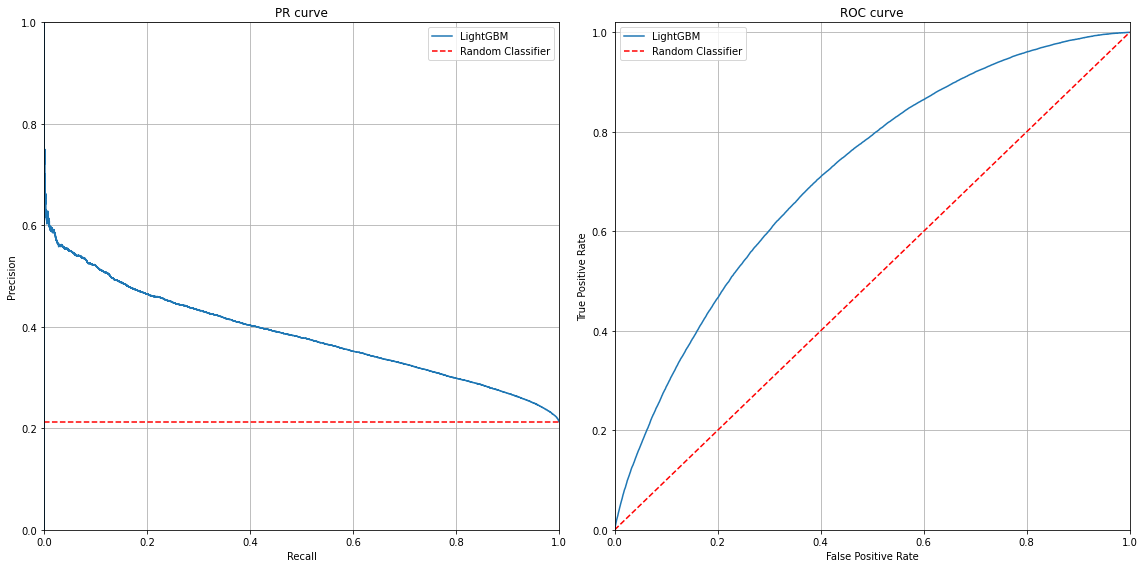

AUC-PR - 0.38553
AUC-ROC - 0.71272
MEAN AUC-PR - 0.38553
MEAN AUC-ROC - 0.71272


,random_classifier,LightGBM,LightGBM_train,LightGBM_drop_features
Precision,0.500000,0.605590,0.621578,0.605594
Recall,0.500000,0.654729,0.685800,0.654850
AUC-PR,0.197521,0.386398,0.426281,0.385557
AUC-ROC,0.500000,0.712858,0.754002,0.712723
F1_score,0.500000,0.590746,0.611895,0.590386
Accuracy,0.682987,0.641919,0.671103,0.641201


In [141]:
gbm = lgb.train(param, dtrain_global, num_boost_round=1000)
preds = gbm.predict(X_test)
preds_0_1 = np.where((preds >= 0.5), 1, 0)

precision = precision_score(y_test, preds_0_1, average='macro')
recall = recall_score(y_test, preds_0_1, average='macro')
AUC_PR = average_precision_score(y_test, preds)
AUC_ROC = roc_auc_score(y_test, preds)
f1 = f1_score(y_test, preds_0_1, average='macro')
accuracy = accuracy_score(y_test, preds_0_1)
results['LightGBM_drop_features'] = [precision, recall, AUC_PR, AUC_ROC, f1, accuracy]

print(classification_report(y_test, np.where((preds >= 0.5), 1, 0)))
plot_AUC([y_test], [preds])
results

### 5.  e) Устойчивость модели во времени? Будем использовать кроссвалидацию с расширающимся окном

In [145]:
folds = TimeSeriesSplit(n_splits=5)
list_preds = []
list_true = []
for train_index, test_index in tqdm(folds.split(X_global_train, y_global_train)):
    X_tr, X_te = X_global_train.loc[train_index], X_global_train.loc[test_index]
    y_tr, y_te = y_global_train.loc[train_index], y_global_train.loc[test_index]
    dtrain = lgb.Dataset(X_tr, label=y_tr, categorical_feature=cat, free_raw_data=False)
    gbm = lgb.train(param, dtrain, num_boost_round=1000)
    preds = gbm.predict(X_te)
    list_preds.append(preds)
    list_true.append(y_te.values)

5it [05:38, 67.75s/it]


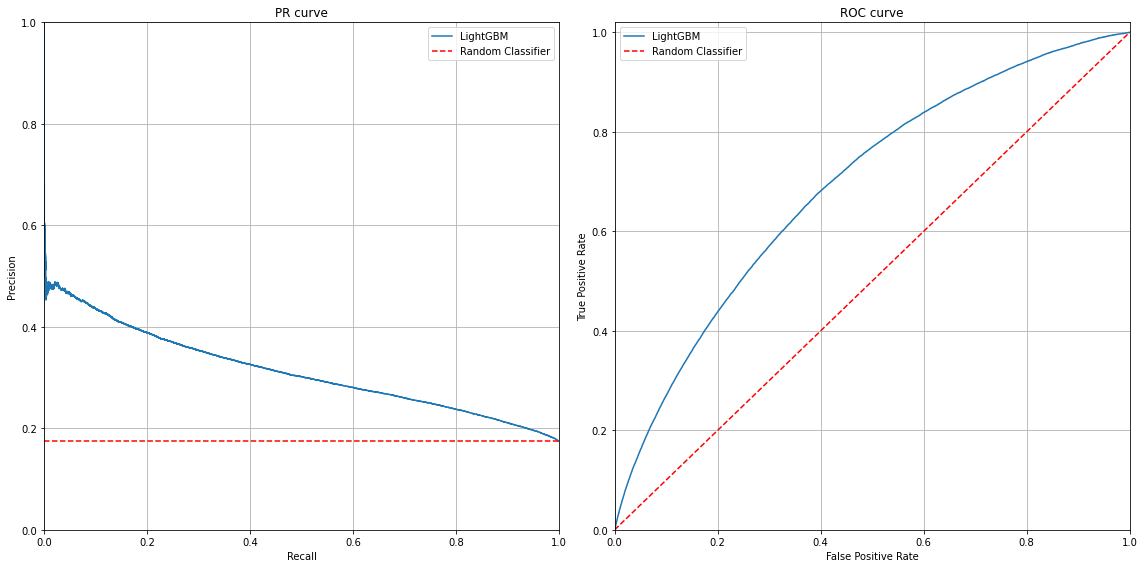

AUC-PR - 0.31286
AUC-ROC - 0.69126


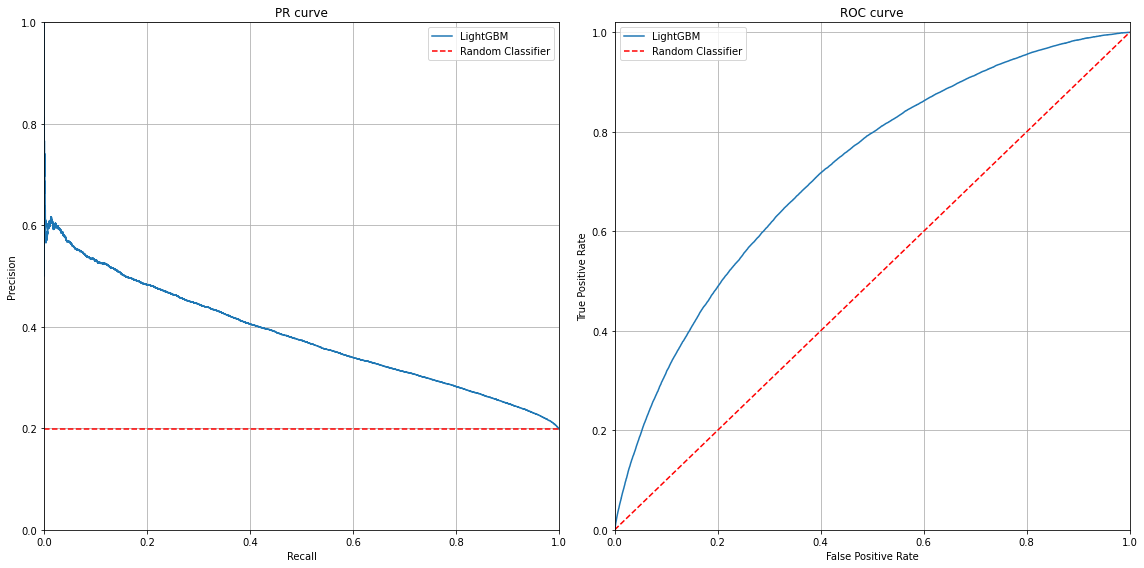

AUC-PR - 0.38289
AUC-ROC - 0.71894


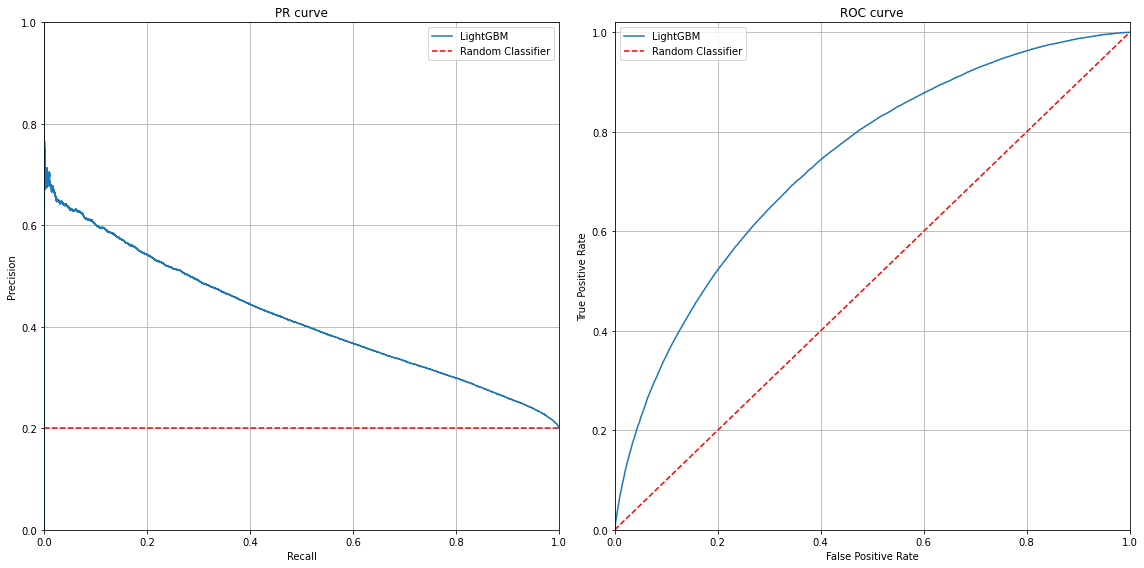

AUC-PR - 0.41881
AUC-ROC - 0.73865


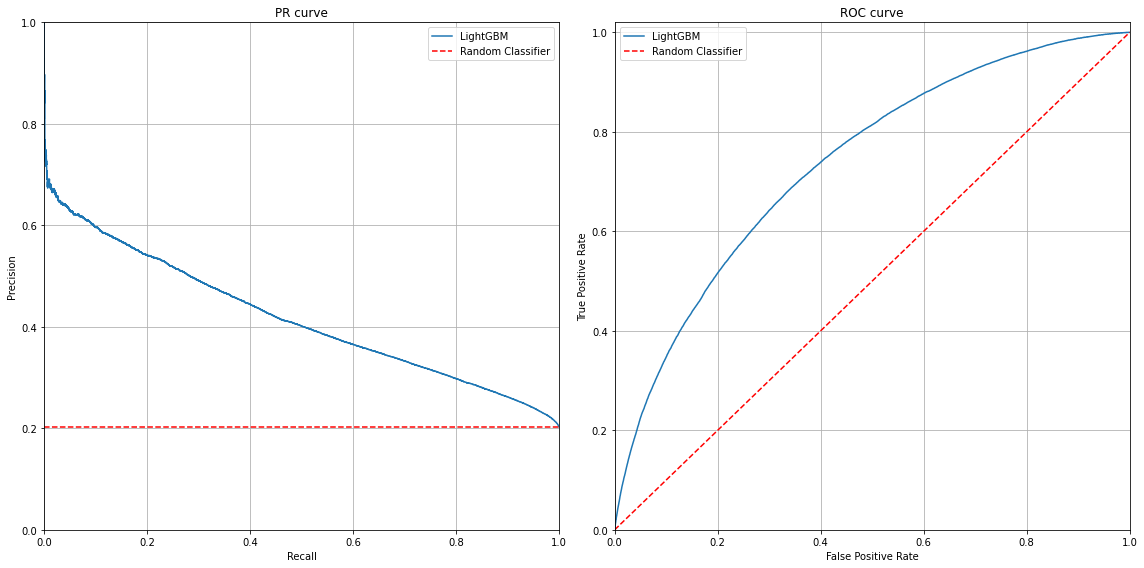

AUC-PR - 0.41823
AUC-ROC - 0.73629


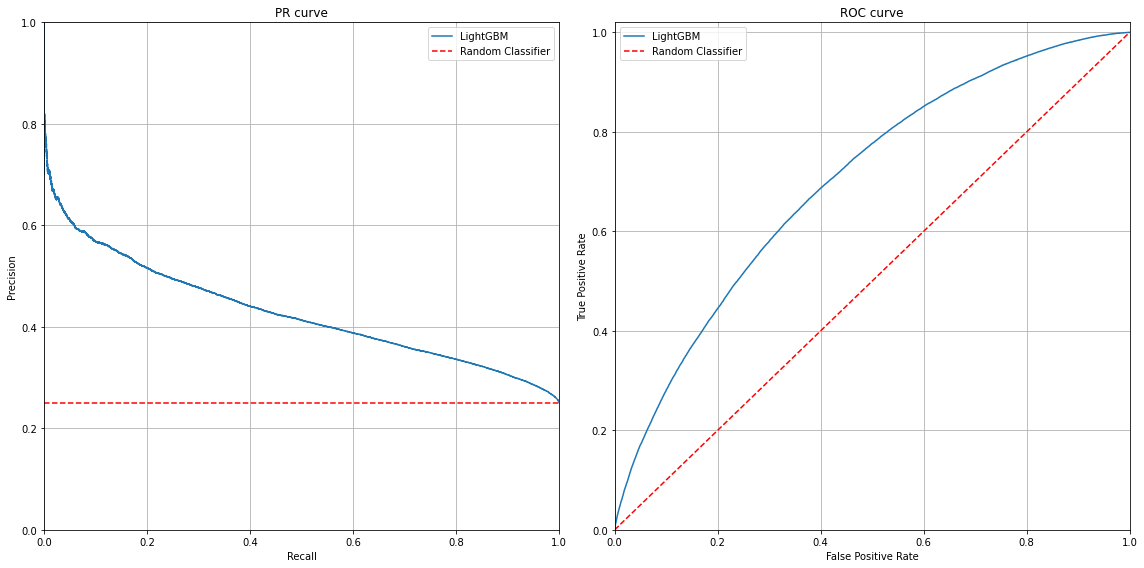

AUC-PR - 0.42815
AUC-ROC - 0.70007
MEAN AUC-PR - 0.39219
MEAN AUC-ROC - 0.71704


In [157]:
plot_AUC(list_true, list_preds)